### Configuration

In [1]:
args = {
  'country': 'united_states',
  'start_year': 1960,
  'end_year': 2020, # exclusive
  'real_gdp_scale': 1000000,
  'bubble_scale': 0.5,
  'bubble_min_count': 100,
}

### Libraries

In [34]:
import pandas as pd
import importlib

import constants.tags as IndustryConstants
import utils.file as File
import utils.data as DataUtils
import utils.visualiser as Visualiser

import utils.firm as FirmUtils
import utils.investor as InvestorUtils

STEM_stack_labels = ['Not STEM', 'STEM']
STEM_stack_colors = ['green', 'lightgreen']
public_funded_stack_labels = ['Private Funded', 'Public Funded']
public_funded_stack_colors = ['blue', 'lightblue']

def get_scaled_year_count(year_count, real_gdp):
  scaled_year_count = year_count / real_gdp.loc[year_count.index] * args['real_gdp_scale']

  return scaled_year_count

def get_STEM_public_year_percent(firms):
  STEM_public_year_percent = DataUtils.get_grouped_percent(firms, ['Founded Year', 'Science', 'Public Funded']) \
    .unstack() \
    .reset_index() \
    .set_index('Founded Year')
  return STEM_public_year_percent

def visualise_industry_group(firms, industry_group, industry_year_count_map, bubble_industries):
  industry_group_firms = DataUtils.filter_industry_group(firms, industry_group)

  industry_group_year_count = DataUtils.get_year_count(industry_group_firms)
  industry_group_public_year_count = DataUtils.get_public_year_count(industry_group_firms)
  industry_group_public_year_percent = DataUtils.get_public_year_percent(industry_group_firms)

  Visualiser.plot(industry_group_year_count, 'Firms Founded', 'Count')
  Visualiser.plot_dict(industry_group_public_year_count, 'Firms Founded', 'Log Count', public_funded_stack_colors)
  Visualiser.stack(industry_group_public_year_percent, 'Public Funded Firms (Percent)', public_funded_stack_labels, colors=public_funded_stack_colors)

  industry_group_industries = DataUtils.get_industry_group_industries(industry_group)
  for industry in industry_group_industries:
    if industry in bubble_industries:
        Visualiser.plot(industry_year_count_map[industry], industry, 'Count')


def visualise_bubble(firms, industry, real_gdp, fed_rate):
  industry_firms = DataUtils.filter_industry(firms, industry)
  industry_year_count = DataUtils.get_year_count(industry_firms)
  industry_public_year_count = DataUtils.get_public_year_count(industry_firms)

  industry_bubble = {
    'All': industry_year_count,
    'Private Funded': industry_public_year_count['Private Funded'],
    'Public Funded': industry_public_year_count['Public Funded'],
    'Interest Rate': fed_rate,
  }
  
  Visualiser.plot_dict(industry_bubble, f"Bubble: {industry}", '')

### Load Data

In [3]:
# Read Company Data
firms = File.read_pickle(f"{args['country']}_firms")

In [4]:
# Read Investor Data
investors = File.read_pickle(f"investors")

In [5]:
# Get Public Investors
public_investor_list = InvestorUtils.get_public_investors(investors).tolist()

In [6]:
# Read Domain Data
domain_created_year_map = File.read_pickle('domain_created_year_map')

In [7]:
# Update Company Data
firms = FirmUtils.enrich_founded_year(firms, domain_created_year_map)
firms = FirmUtils.enrich_stem(firms, IndustryConstants.stem_tags)
firms = FirmUtils.enrich_public_funded(firms, public_investor_list)
firms = firms[firms['Company Type'] == 'For Profit']
firms = firms[pd.notna(firms['Founded Year'])]
firms = firms[firms['Founded Year'] >= args['start_year']]
firms = firms[firms['Founded Year'] < args['end_year']]
firms = firms.reset_index(drop=True)

In [8]:
# Read Macro Data
real_gdp = File.read_pickle('real_gdp')
fed_rate = File.read_pickle('fed_rate')

In [9]:
# Update Macro Data
real_gdp = real_gdp['United States']
real_gdp = real_gdp[real_gdp.index >= args['start_year']]
real_gdp = real_gdp[real_gdp.index < args['end_year']]

fed_rate = fed_rate[fed_rate.index >= args['start_year']]
fed_rate = fed_rate[fed_rate.index < args['end_year']]

### Broad Facts

In [10]:
year_count = DataUtils.get_year_count(firms)
scaled_year_count = get_scaled_year_count(year_count, real_gdp)

STEM_year_percent = DataUtils.get_STEM_year_percent(firms)
public_year_percent = DataUtils.get_public_year_percent(firms)
STEM_public_year_percent = get_STEM_public_year_percent(firms)

# To Do, get recession yars

In [ ]:
print(real_gdp)
Visualiser.plot(year_count, 'Real GDP', 'USD Millions')

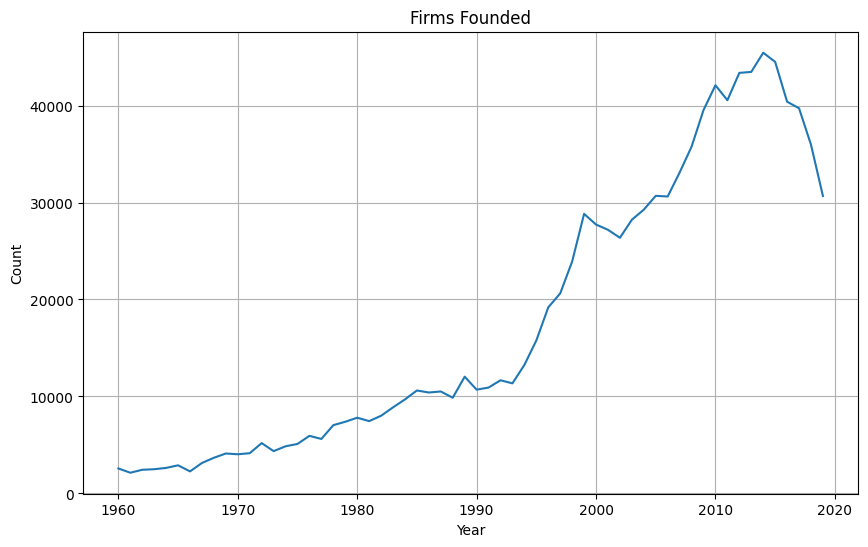

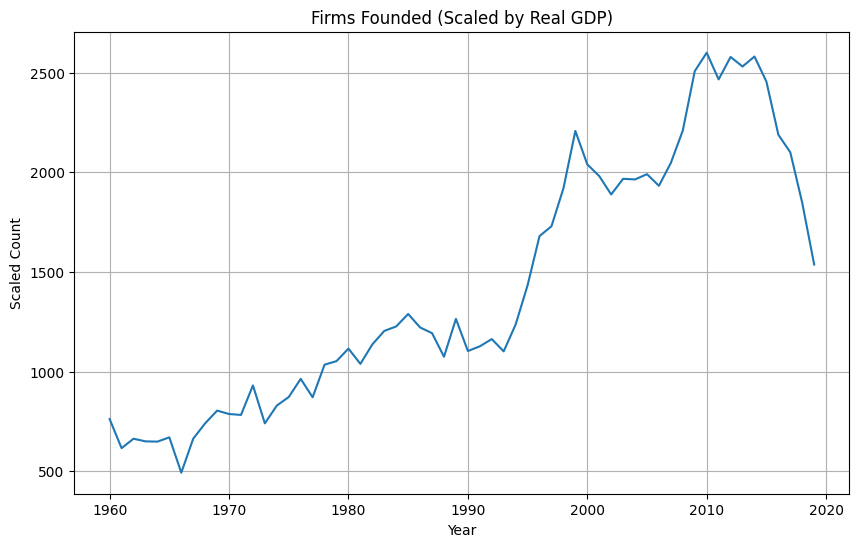

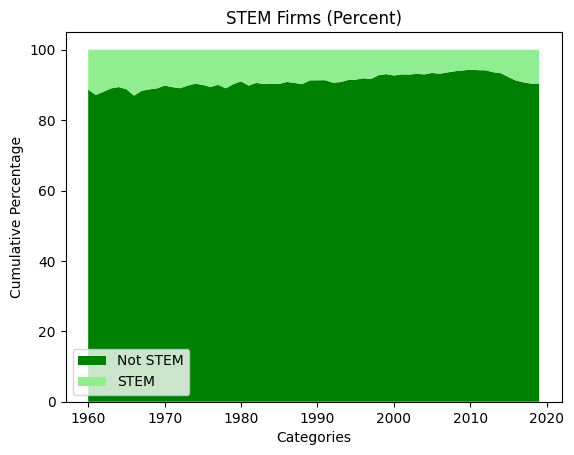

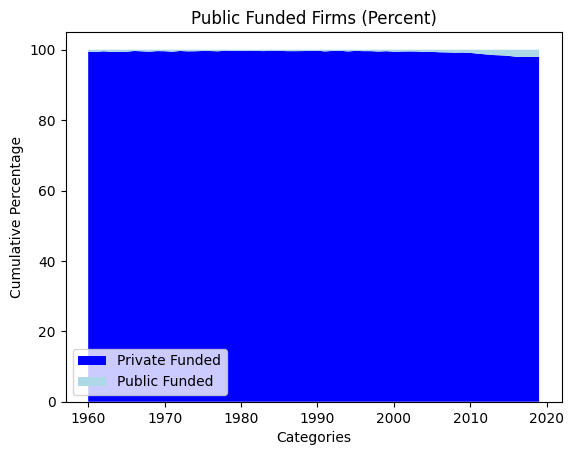

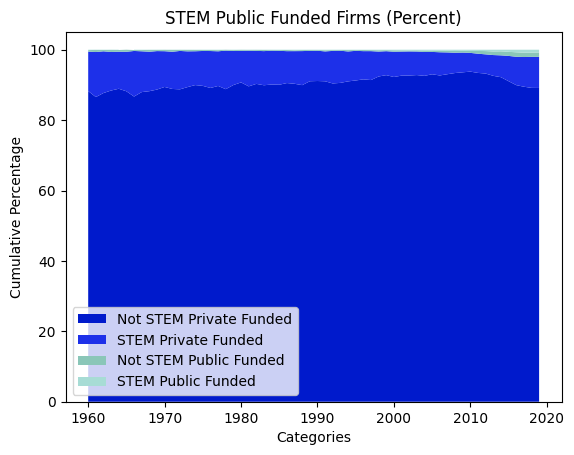

In [11]:
# To Do, add interest rate

Visualiser.plot(year_count, 'Firms Founded', 'Count')
Visualiser.plot(scaled_year_count, 'Firms Founded (Scaled by Real GDP)', 'Scaled Count')
Visualiser.stack(STEM_year_percent, 'STEM Firms (Percent)', STEM_stack_labels, colors=STEM_stack_colors)
Visualiser.stack(public_year_percent, 'Public Funded Firms (Percent)', public_funded_stack_labels, colors=public_funded_stack_colors)

STEM_public_year_percent_colors = [Visualiser.mid_color('green','blue', 0.8), Visualiser.mid_color('lightgreen', 'blue', 0.8),  Visualiser.mid_color('green', 'lightblue', 0.8),  Visualiser.mid_color('lightgreen', 'lightblue', 0.8)]

Visualiser.stack(STEM_public_year_percent, 'STEM Public Funded Firms (Percent)', 
                 ['Not STEM Private Funded', 'STEM Private Funded', 'Not STEM Public Funded', 'STEM Public Funded'], STEM_public_year_percent_colors)

In [13]:
industries = DataUtils.get_industries()

bubble_industries = []
industry_year_count_map = {}
industry_bubble_scale_map = {}

for industry in industries:
  industry_firms = DataUtils.filter_industry(firms, industry)
  industry_year_count = DataUtils.get_year_count(industry_firms)
  industry_max_count = industry_year_count.max()

  industry_year_count_map[industry] = industry_year_count

  industry_current_count = industry_max_count
  for year in range(args['end_year'], 0, -1):
    if year in industry_year_count:
        industry_current_count = industry_year_count[year]
        break
  
  industry_bubble_scale = industry_current_count / industry_max_count
  industry_bubble_scale_map[industry] = industry_bubble_scale

  if industry_max_count > args['bubble_min_count'] and args['bubble_scale'] > industry_bubble_scale:
    bubble_industries.append(industry)

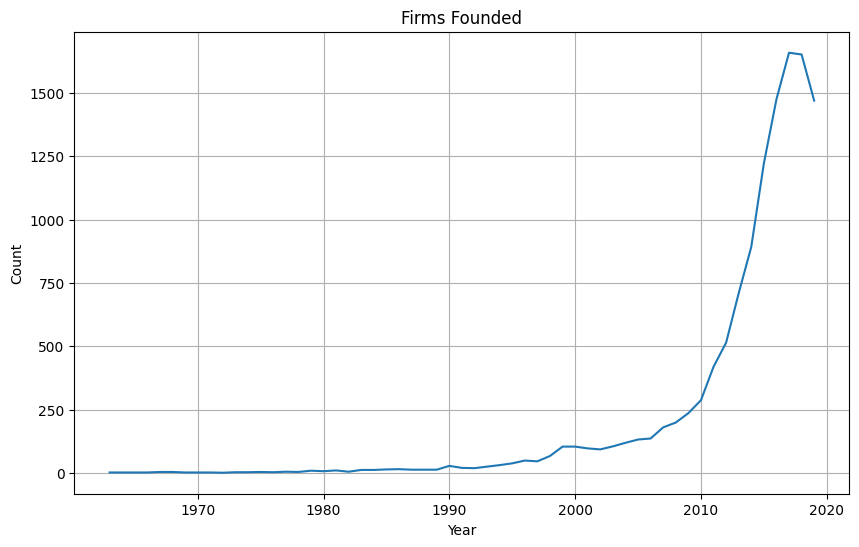

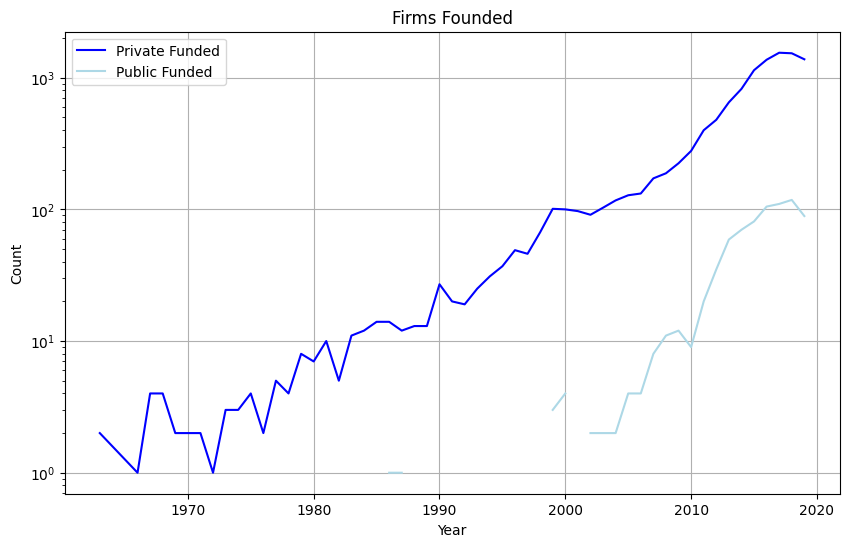

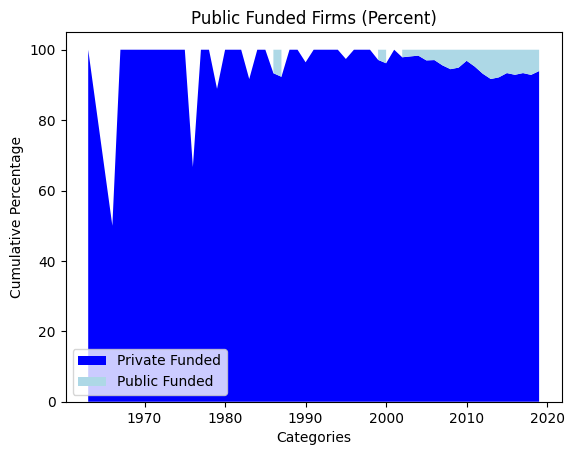

In [19]:
visualise_industry_group(firms, 'Artificial Intelligence (AI)', industry_year_count_map, bubble_industries)

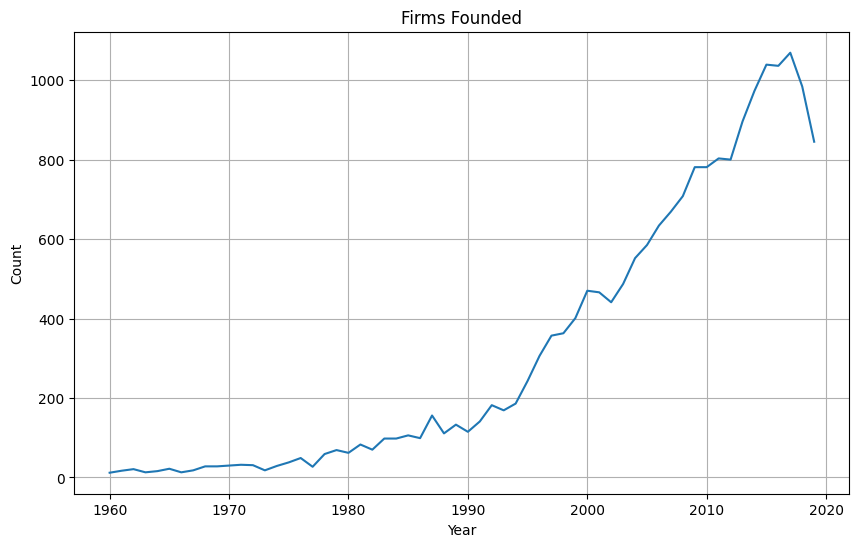

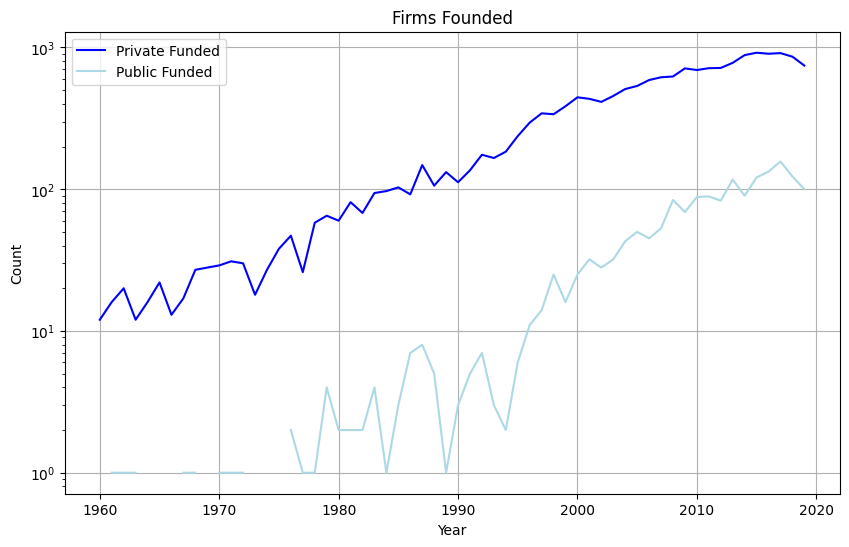

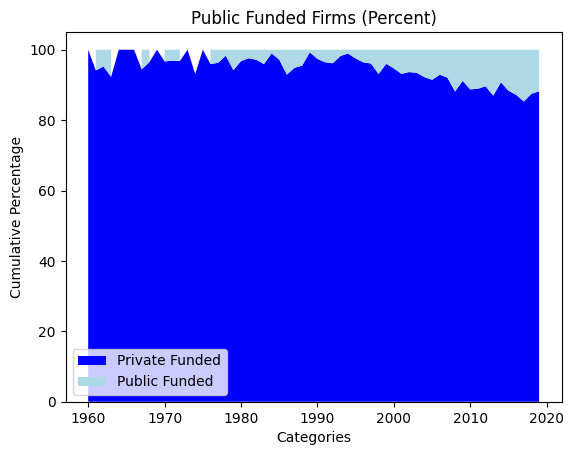

In [20]:
visualise_industry_group(firms, 'Biotechnology', industry_year_count_map, bubble_industries)

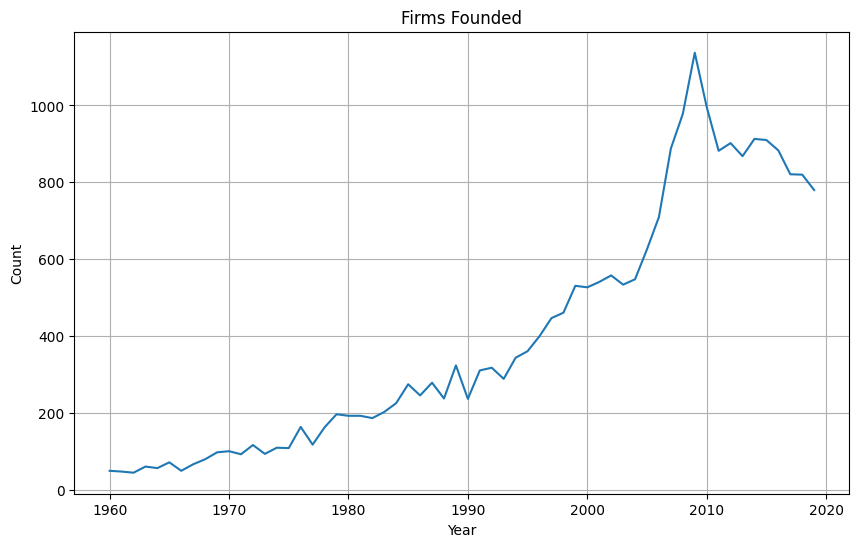

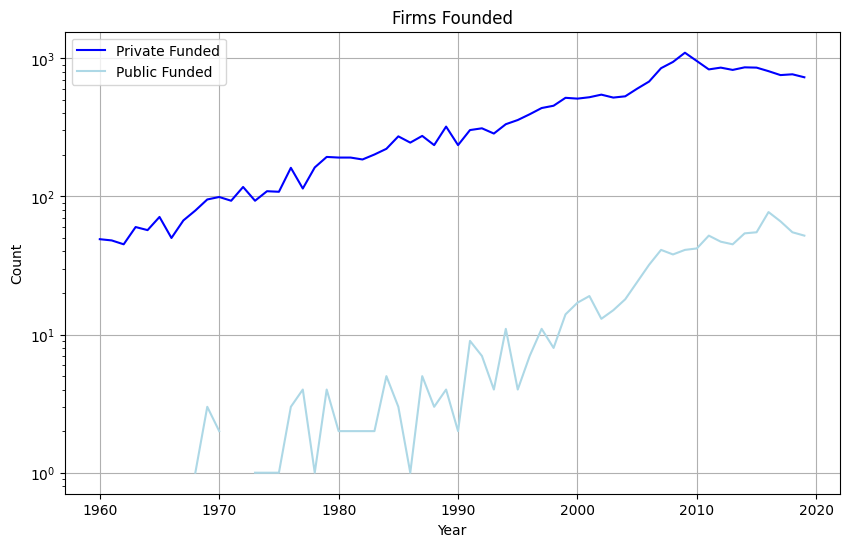

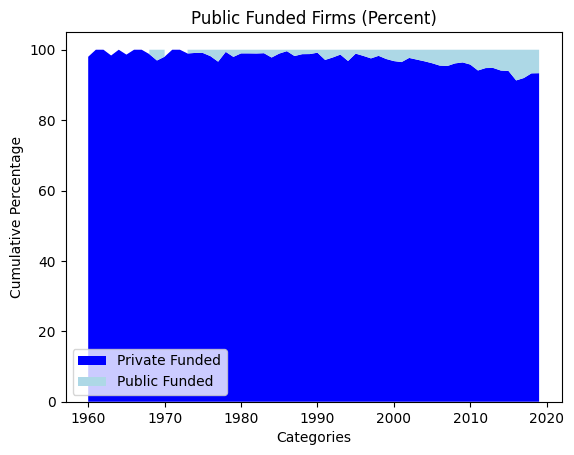

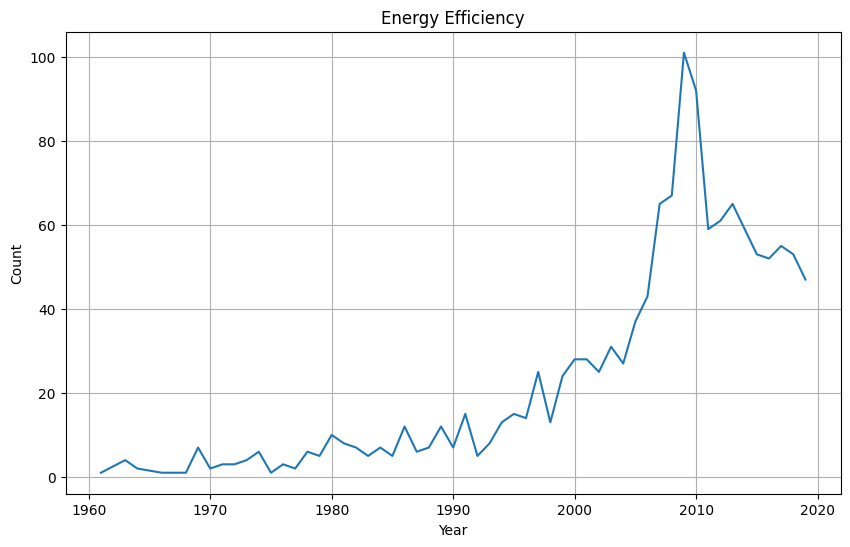

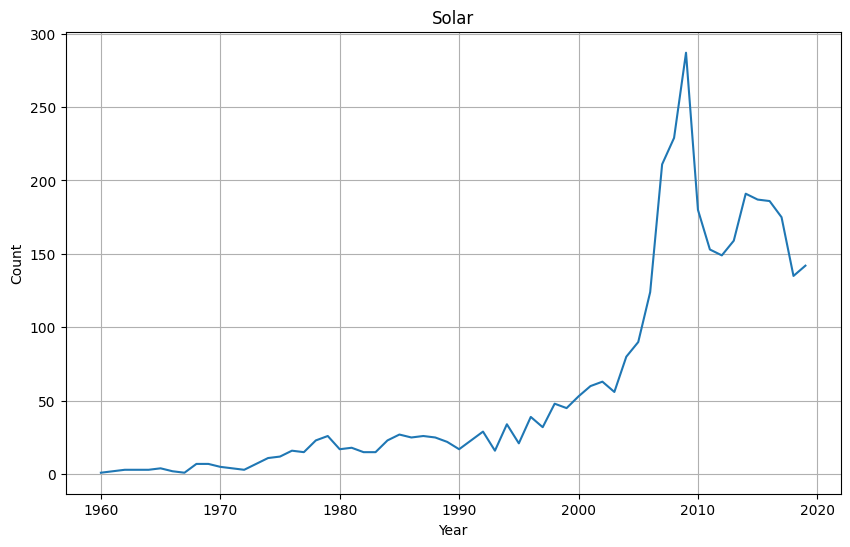

In [23]:
visualise_industry_group(firms, 'Sustainability', industry_year_count_map, bubble_industries)

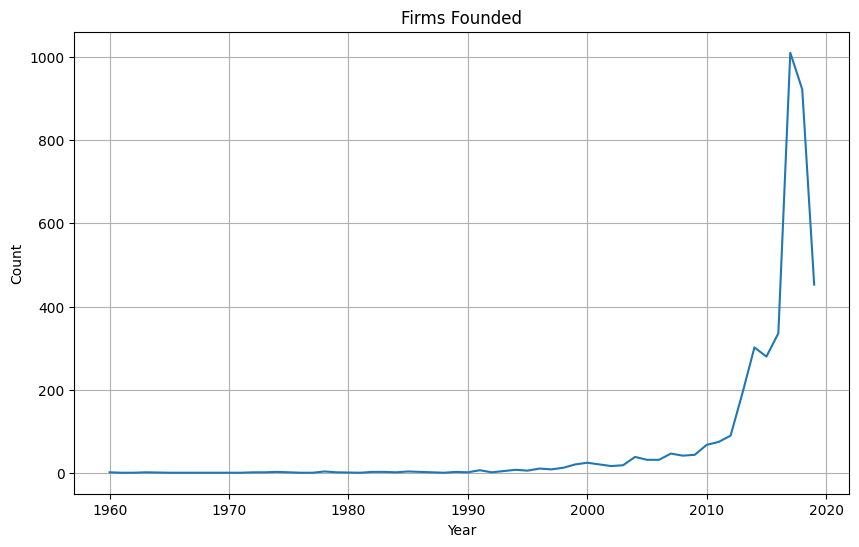

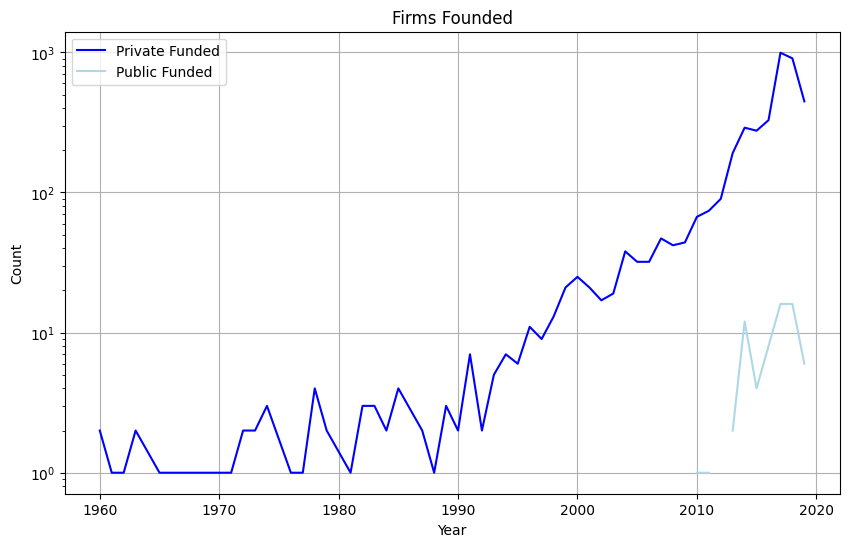

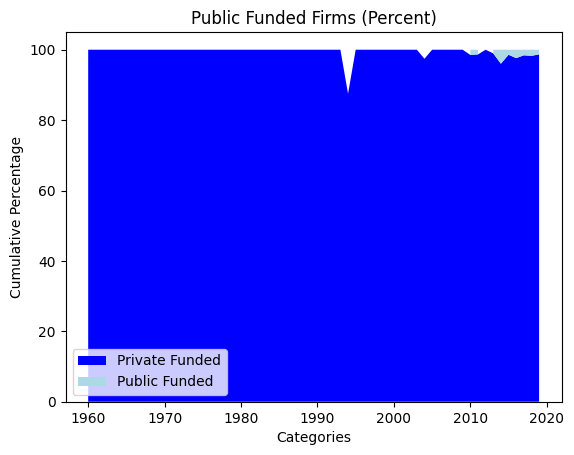

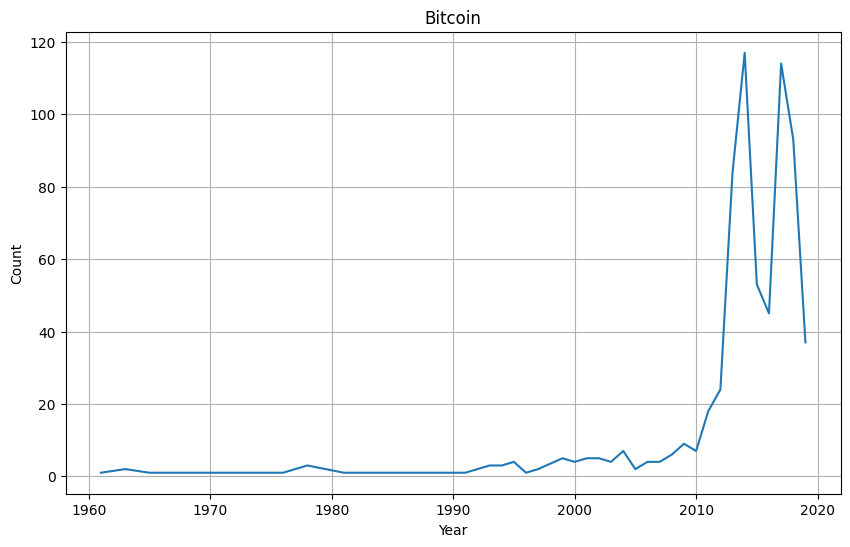

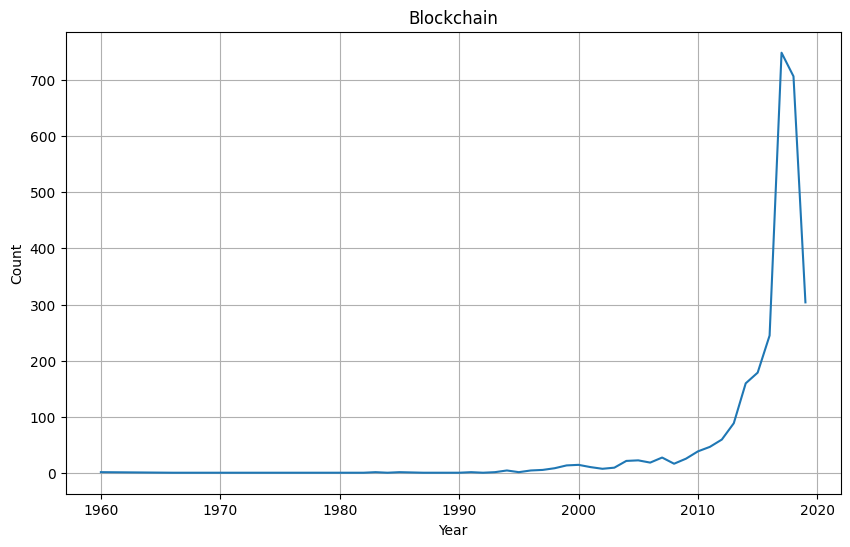

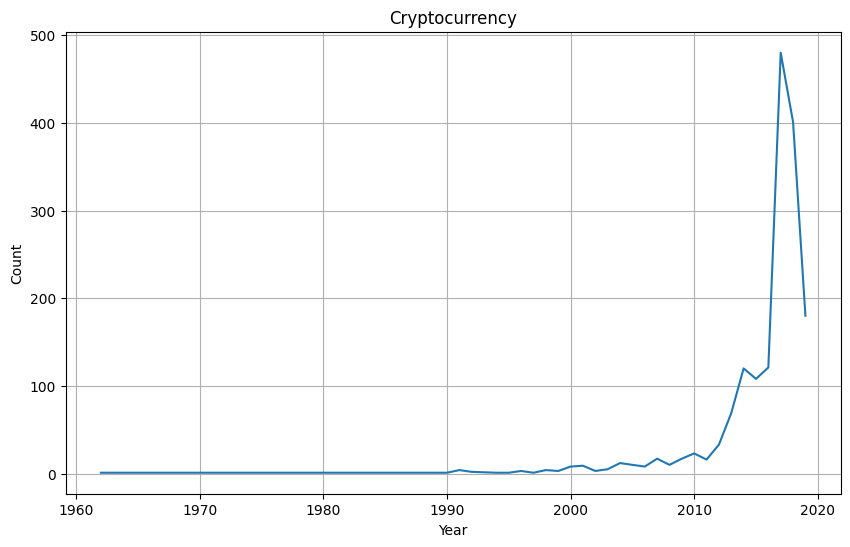

In [22]:
visualise_industry_group(firms, 'Blockchain and Cryptocurrency', industry_year_count_map, bubble_industries)

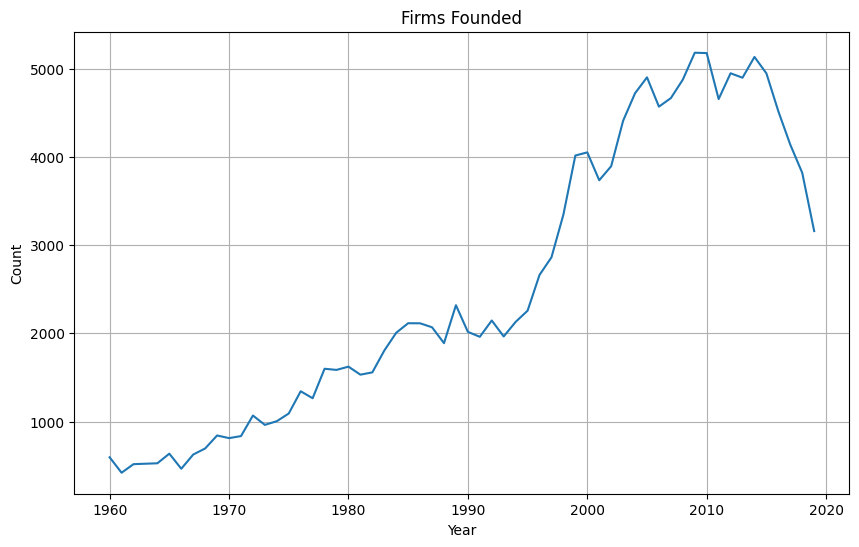

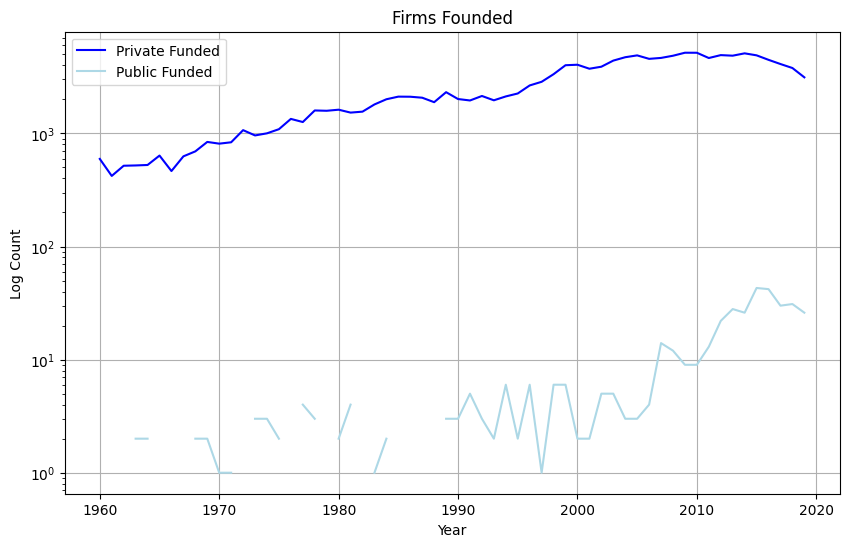

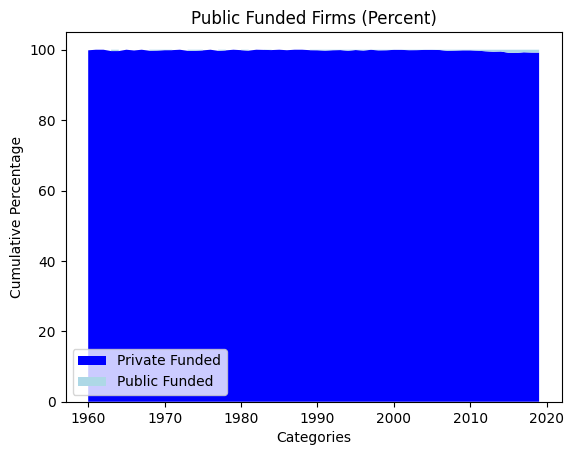

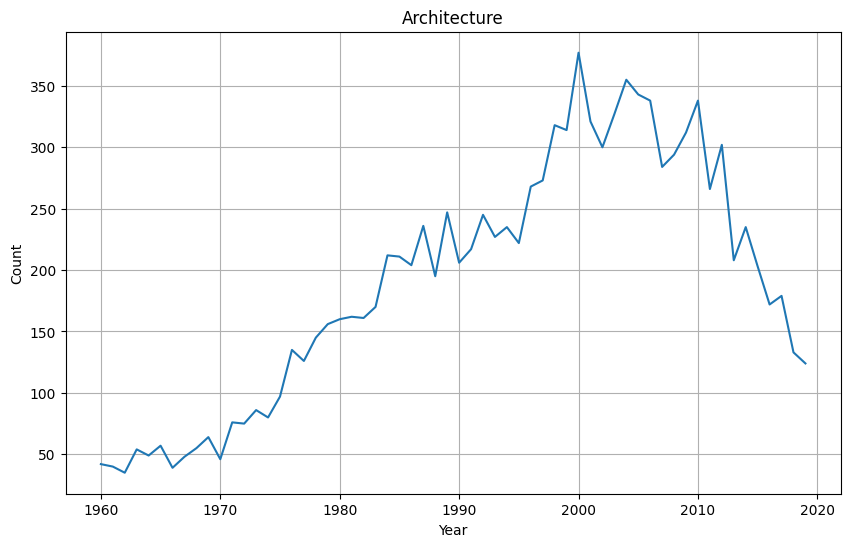

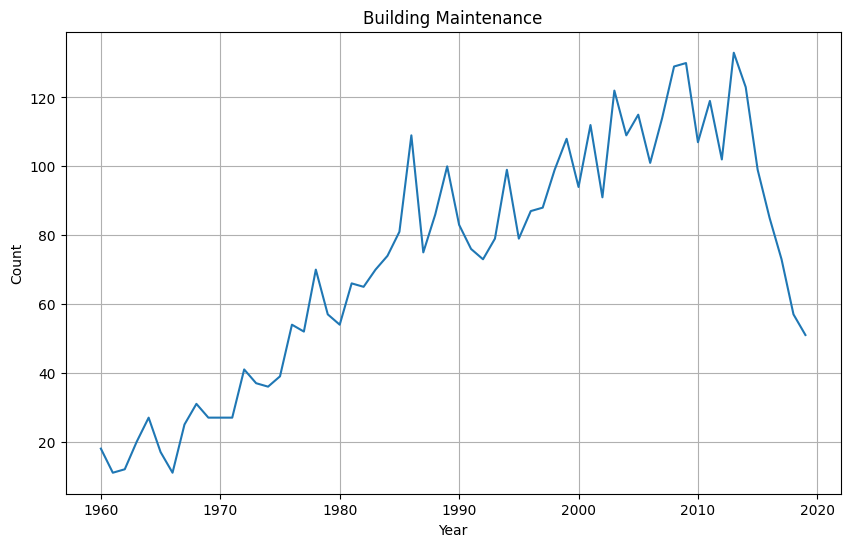

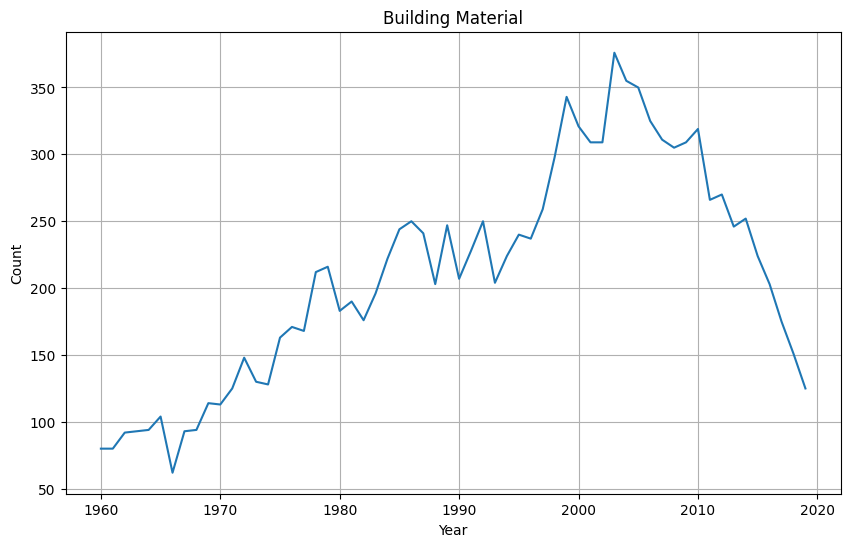

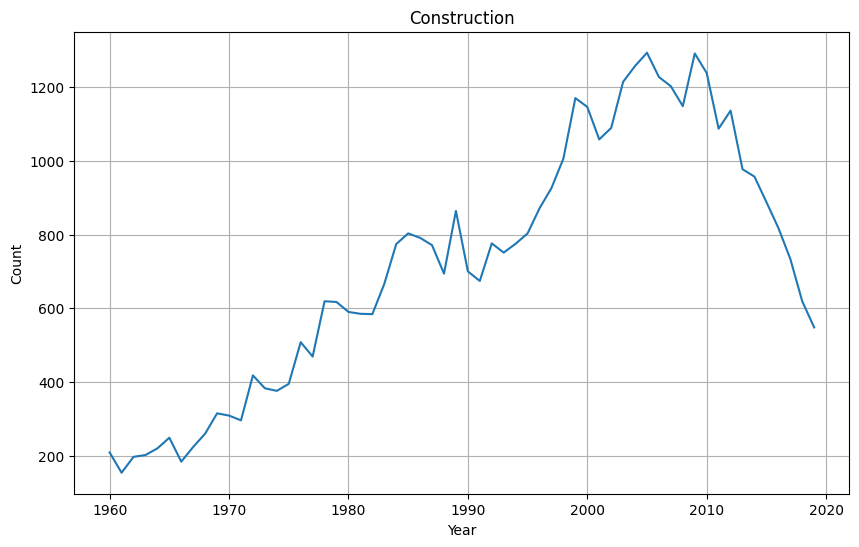

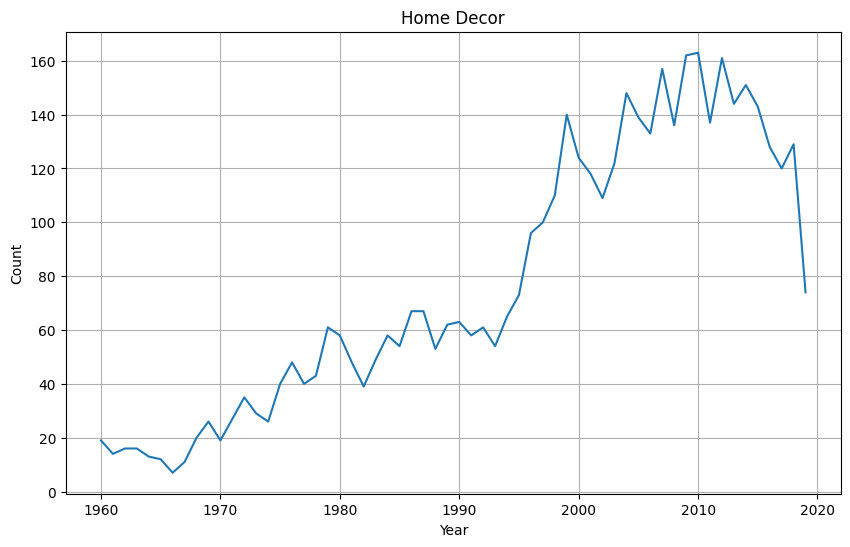

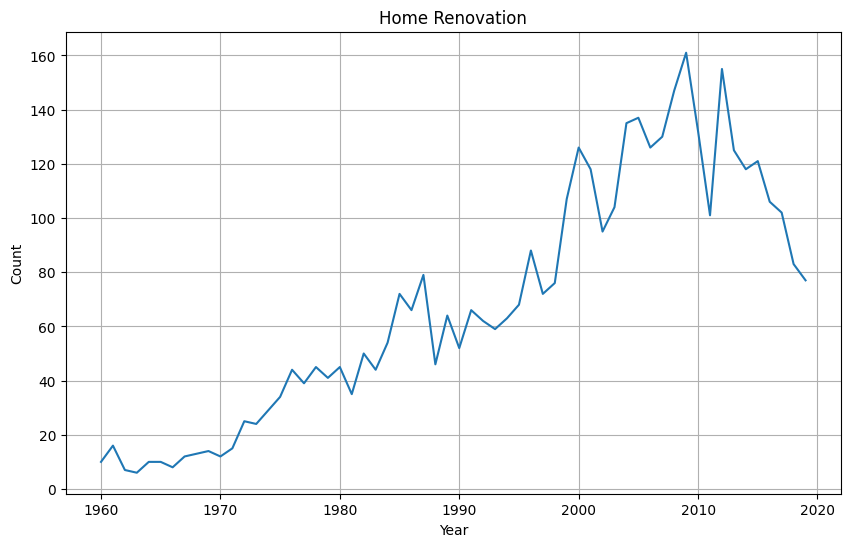

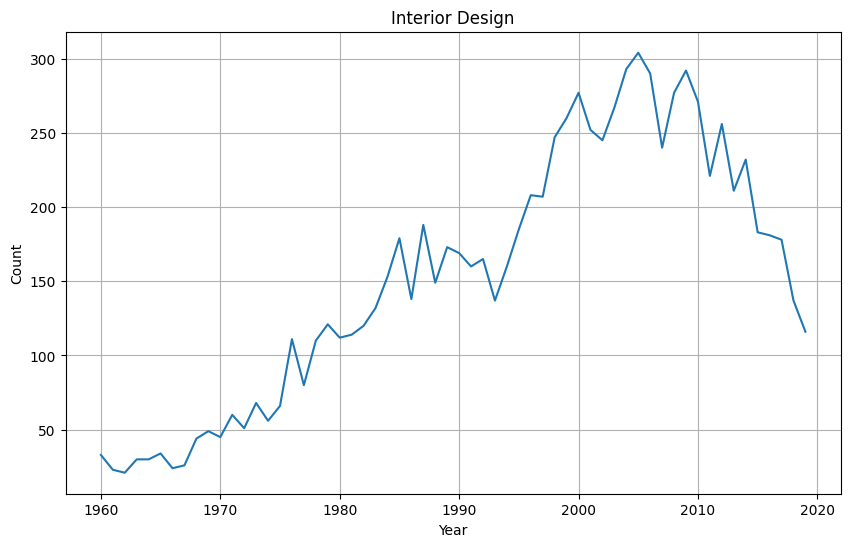

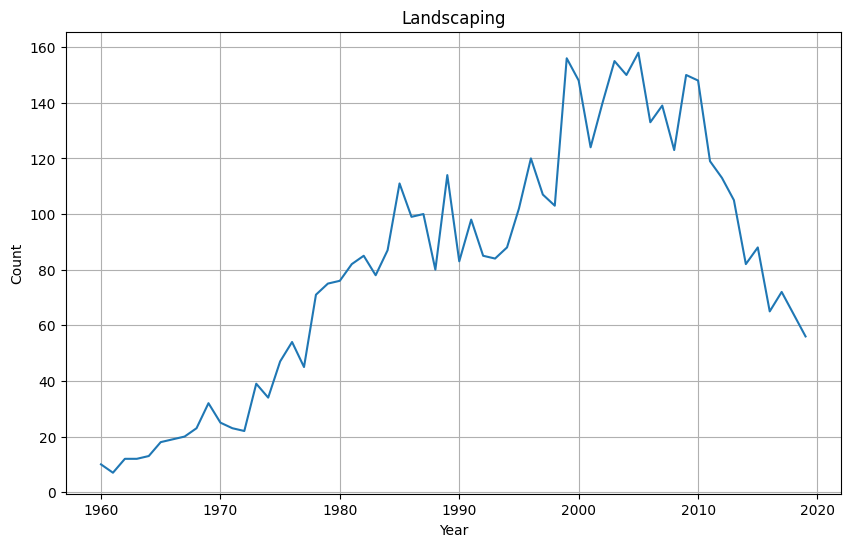

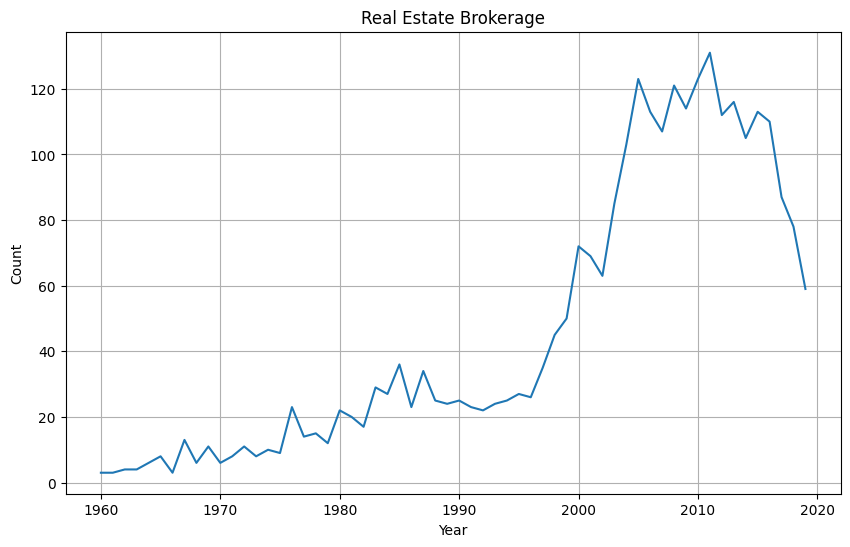

In [38]:
visualise_industry_group(firms, 'Real Estate', industry_year_count_map, bubble_industries)

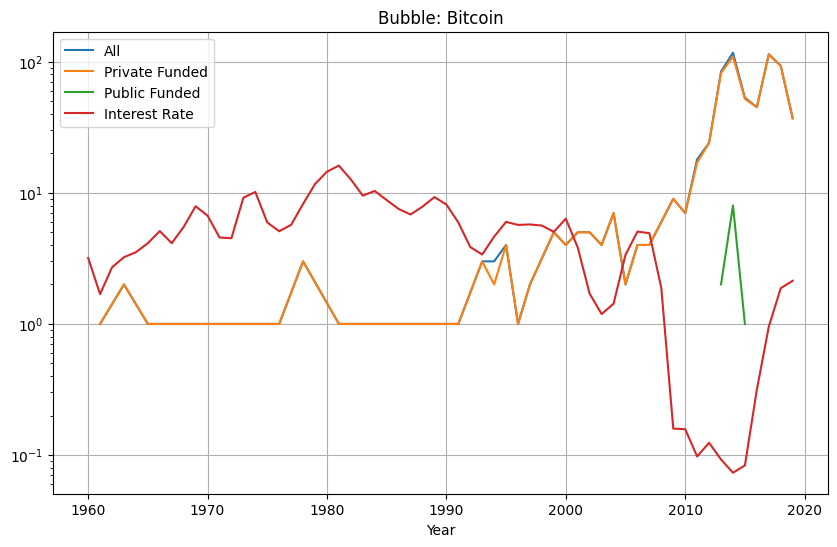

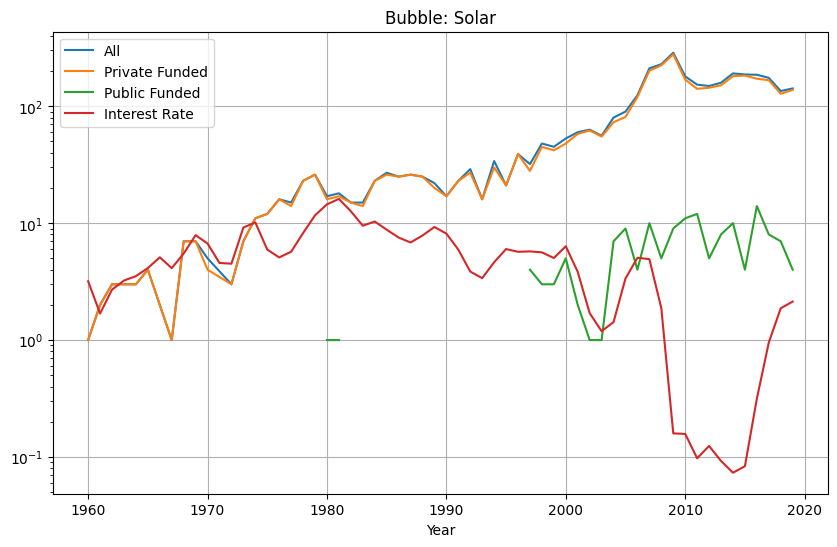

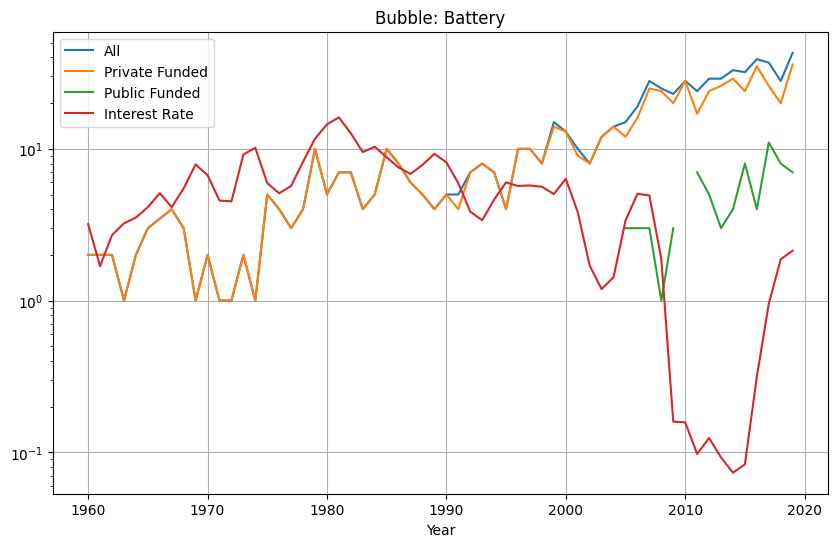

In [37]:

visualise_bubble(firms, 'Bitcoin', real_gdp, fed_rate)

visualise_bubble(firms, 'Solar', real_gdp, fed_rate)

visualise_bubble(firms, 'Battery', real_gdp, fed_rate)